# Beer Production 

In [1]:
from functools import reduce
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from darts.datasets import AusBeerDataset
from darts.utils.statistics import (
    plot_acf,
    plot_pacf,
    plot_hist,
    plot_residuals_analysis,
    check_seasonality,
    seasonal_decompose
)

from darts.metrics import mae, mape, mase, r2_score
from darts.models import (
    NaiveDrift,
    NaiveSeasonal,
    ARIMA,
    AutoARIMA,
    ExponentialSmoothing,
    Prophet,
    Theta,
    RegressionEnsembleModel,
    RegressionModel,
)

import warnings
warnings.filterwarnings('ignore')
import logging
logging.disable(logging.CRITICAL)

from darts_forecasting_utils import *

In [2]:
beer = AusBeerDataset().load()

## Data Description

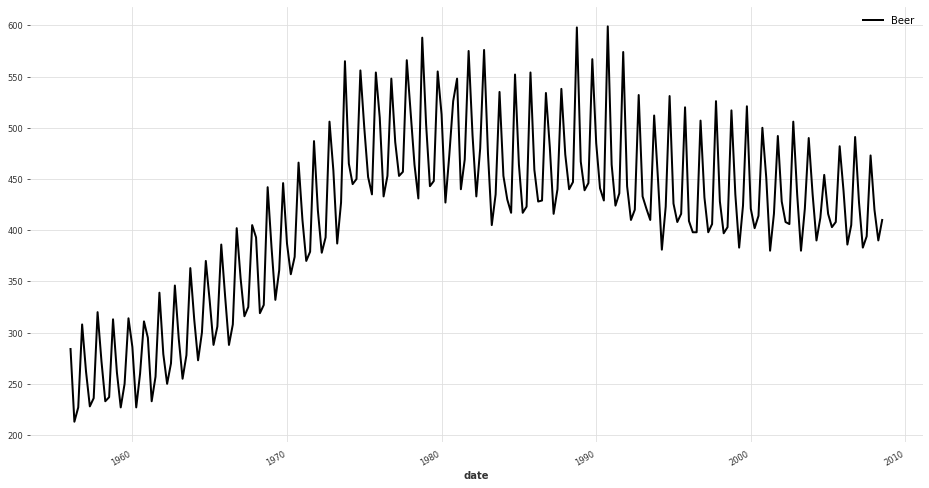

In [3]:
plot_time_series({'Beer': beer})

In [4]:
is_data_seasonal(beer, 12)

Seasonality of degree 4 found!
Seasonality of degree 8 found!
Seasonality of degree 12 found!


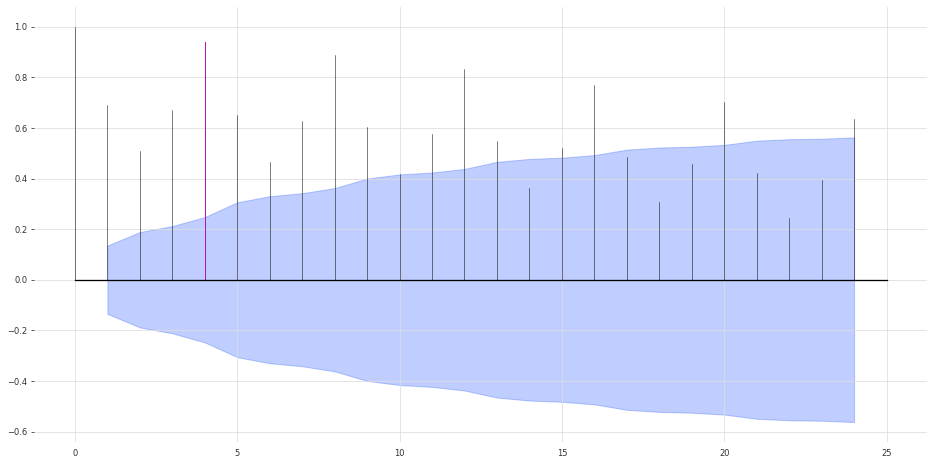

In [5]:
plot_acf(beer, fig_size=(16, 8), m=4)

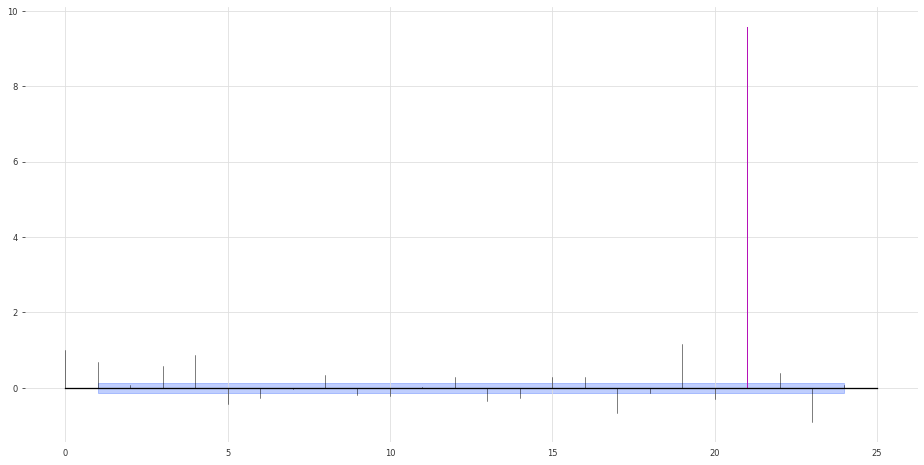

In [6]:
plot_pacf(beer, fig_size=(16, 8), m=21)

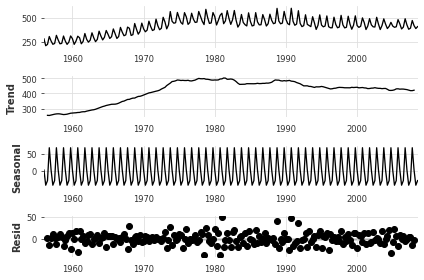

In [7]:
seasonal = seasonal_decompose(beer.pd_dataframe())
_ = seasonal.plot()

## Model Choosing

In [8]:
train, test = beer.split_before(pd.Timestamp('20050101'))

In [9]:
models = (
    NaiveDrift(),
    NaiveSeasonal(K=4),
    NaiveSeasonal(K=8),
    NaiveSeasonal(K=12),
    AutoARIMA(),
    ExponentialSmoothing(seasonal_periods=4),
    Prophet(
        daily_seasonality=False,
        weekly_seasonality=False,
        yearly_seasonality=True
    ),
    Theta(seasonality_period=4),
)

In [10]:
best_model = get_best_model(models, train, mape, stride=6, num_periods=12)

Naive drift model : 9.189370211754838
Naive seasonal model, with K=4 : 4.063668916486064
Naive seasonal model, with K=8 : 4.194799988136152
Naive seasonal model, with K=12 : 4.690478772547503
Auto-ARIMA : 5.031318759854395
Exponential smoothing : 4.594726204922377
Prophet : 4.326256156843115
Theta(2) : 4.1891029698663536


## Parameter Tuning

In [18]:
theta_grid = {'theta': np.linspace(-20, 20, 20),
              'seasonality_period': [4, 8, 12]}
theta_model = Theta()

theta_model = theta_model.gridsearch(
    parameters=theta_grid,
    series=train,
    stride=1,
    forecast_horizon=12,
    n_jobs=-1,
    verbose=True
)[0]

  0%|          | 0/60 [00:00<?, ?it/s]

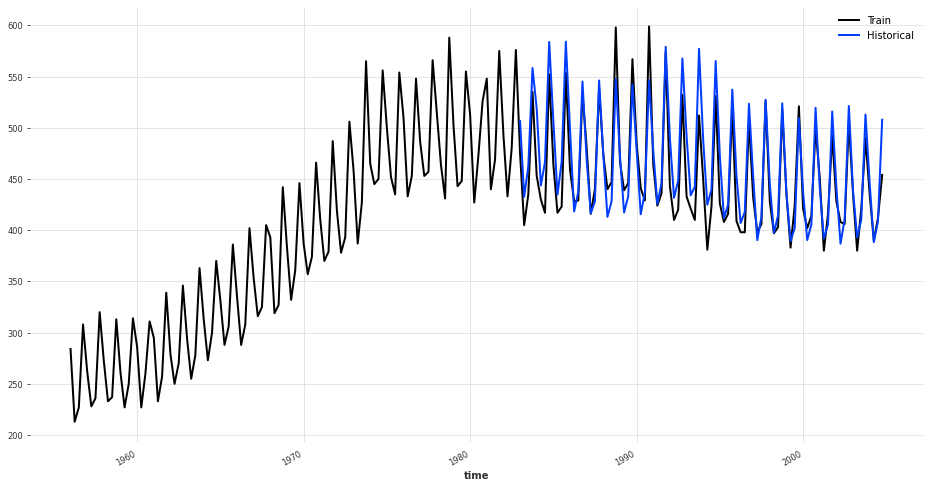

In [19]:
historical =  theta_model.historical_forecasts(train, forecast_horizon=12, stride=1)
plot_time_series({'Train': train, 'Historical': historical})

### Ensembling?

In [20]:
models = [
    NaiveSeasonal(4),
    NaiveSeasonal(8),
    NaiveSeasonal(12),
    NaiveDrift(),
    Theta(theta_model.coef[0])
]

ensemble_model = RegressionEnsembleModel(
    forecasting_models=models,
    regression_train_n_points=24)

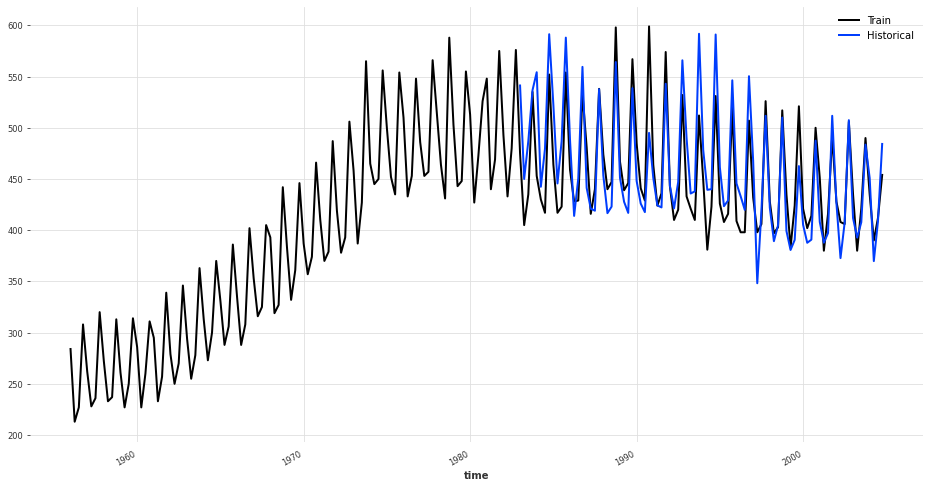

In [21]:
historical =  ensemble_model.historical_forecasts(train, forecast_horizon=12, stride=1)
plot_time_series({'Train': train, 'Historical': historical})

## Evaluation of the model

### Backtesting

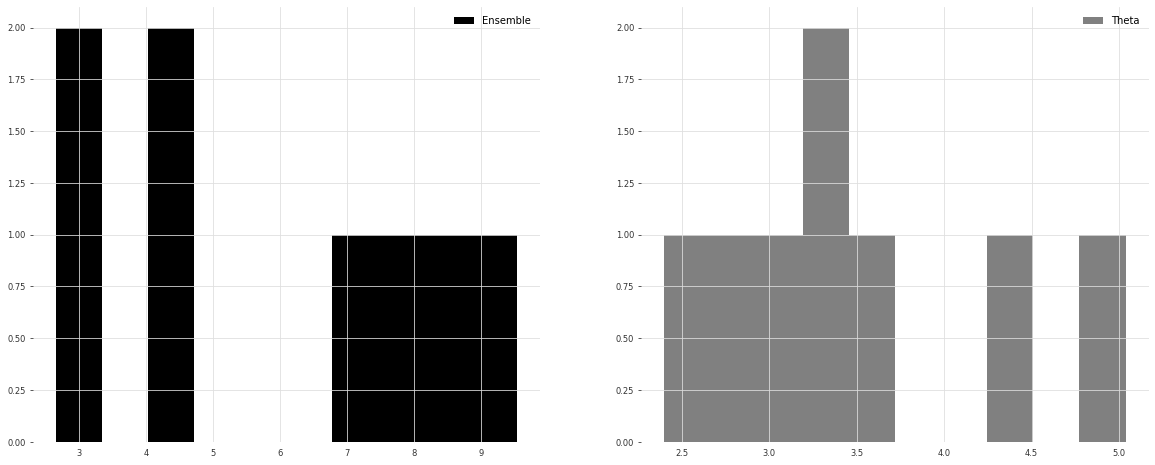

In [22]:
ensemble_errors = ensemble_model.backtest(
    train,
    stride=12,
    forecast_horizon=12,
    metric=mape, 
    reduction=None
)

theta_errors = theta_model.backtest(
    train,
    stride=12,
    forecast_horizon=12,
    metric=mape, 
    reduction=None
)

fig, ax = plt.subplots(figsize=(20, 8), ncols=2)
ax[0].hist(ensemble_errors, label='Ensemble')
ax[0].legend()
ax[1].hist(theta_errors, label='Theta', color='gray')
ax[1].legend()
plt.show()

In [23]:
mae_ensemble = np.mean(list(map(abs, ensemble_errors)))
mae_theta = np.mean(list(map(abs, theta_errors)))

print(f"The error of the ensemble model was {mae_ensemble}")
print(f"The error of the theta model was {mae_theta}")

The error of the ensemble model was 5.914597068065802
The error of the theta model was 3.5079860883429035


## Predictions

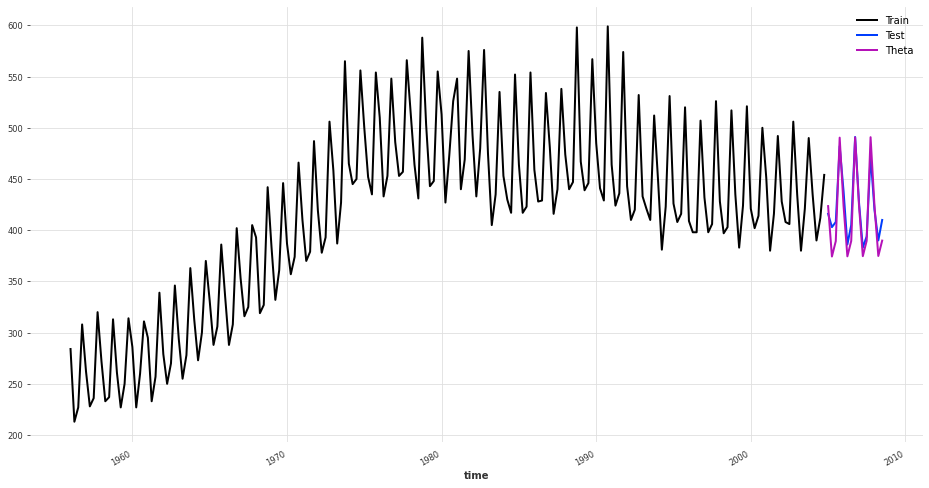

In [25]:
theta_model.fit(train)
theta_pred = theta_model.predict(len(test))
plot_time_series({'Train': train, 'Test': test, 'Theta': theta_pred})

## Conclusions